# Environment

In [26]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile

from scipy.stats import bernoulli
from scipy.stats import beta as bt
from scipy.stats import dirichlet
from scipy.special import digamma
from scipy.stats import loggamma 
from scipy.stats import expon
from scipy.cluster.vq import whiten

import time

import random

In [176]:
data_paths = [["/Users/srivatsavpyda/Desktop/Unsupervised Learning/Homework_3/data/mixed_sound_dataset/dataset1/rsm2_mB.wav", 
        "/Users/srivatsavpyda/Desktop/Unsupervised Learning/Homework_3/data/mixed_sound_dataset/dataset1/rsm2_mA.wav"],
       ["/Users/srivatsavpyda/Desktop/Unsupervised Learning/Homework_3/data/mixed_sound_dataset/dataset2/rss_mB.wav",
       "/Users/srivatsavpyda/Desktop/Unsupervised Learning/Homework_3/data/mixed_sound_dataset/dataset2/rss_mA.wav"],
       ["/Users/srivatsavpyda/Desktop/Unsupervised Learning/Homework_3/data/mixed_sound_dataset/dataset3/rssd_B.wav",
       "/Users/srivatsavpyda/Desktop/Unsupervised Learning/Homework_3/data/mixed_sound_dataset/dataset3/rssd_A.wav"]]

data_paths = np.array(data_paths)

# Functions

## Negentropy Functions

In [177]:
def g_1(u):
    a_1 = 1
    u_cosh = np.cosh(a_1 * u)
    u_log = np.log(u_cosh)
    final = (1/a_1) * u_log
    return final
def g_1_derivative(u):
    a_1 = 1
    return np.tanh(a_1 * u)

In [178]:
def g_2(u):
    return -1 * np.exp(-1 * (u * u) / 2)
def g_2_derivative(u):
    return u * np.exp(-1 * (u * u) / 2)

## Update Functions

In [179]:
def g_1_expectation(w, x, t, sample_size):
    indices = random.sample(range(t), sample_size)
    values = x[:,indices] * g_1(w.dot(x[:,indices]))
    values_sum = np.sum(x, axis=1)
    values_mean = values_sum / sample_size
    #values_mean = np.mean(values, axis=1)
    return values_mean

In [180]:
a = np.array([[ 5, 1 ,3], 
                  [ 1, 1 ,1]])
b = np.array([1, 2])
print(a / np.linalg.norm(a, axis=1)[np.newaxis,:].T)
print(a[0,1] / np.linalg.norm(a, axis=1)[np.newaxis,:].T[1,0])
#print(b.dot(a))
#print(b[np.newaxis, :].T - b[np.newaxis, :].T * a)

[[ 0.84515425  0.16903085  0.50709255]
 [ 0.57735027  0.57735027  0.57735027]]
0.57735026919


In [181]:
def g_1_derivative_expectation(w, x, t, sample_size):
    indices = random.sample(range(t), sample_size)
    values = g_1_derivative(w.dot(x[:,indices]))
    final_value = np.mean(values, axis=1)
    return final_value

In [182]:
def update_w(w, x, t, sample_size):
    g_exp = g_1_expectation(w, x, t, sample_size)
    g_der_exp = g_1_derivative_expectation(w, x, t, sample_size)
    #print(g_der_exp)
    w_new = g_exp[np.newaxis,:].T - g_der_exp[np.newaxis,:].T * w
    w_new = w_new / np.linalg.norm(w_new, axis=1)[np.newaxis,:].T
    return w_new

# Convergence Measures

In [183]:
def w_has_converged(w, w_new, threshold):
    s = 0
    for i in range(w.shape[0]):
        s = s + w[i,:].dot(w_new[i,:])
    sum_altered = np.absolute(1-s)
    if sum_altered <= threshold:
        return sum_altered, s, True
    return sum_altered, s, False

# Data Preparation

## Hyperparameters

In [184]:
sample_size = 1000
n = 2
d = 2
threshold = 0.01

## Data Loading

In [185]:
def center(z):
    return z / np.mean(z)

In [186]:
current_sample = 0
rates = []
data = []
for i in range(n):
    rate, dat = scipy.io.wavfile.read(data_paths[current_sample,i])
    rates.append(rate)
    
    dat = center(dat)
    data.append(dat)

## Variables

In [187]:
t = data[0].shape[0]
x = np.zeros((n, t))
                                              
for i in range(n):
    x[i,:] = data[i]
    
x = whiten(x)
    
w = np.random.rand(n, d)

### Data Visualization

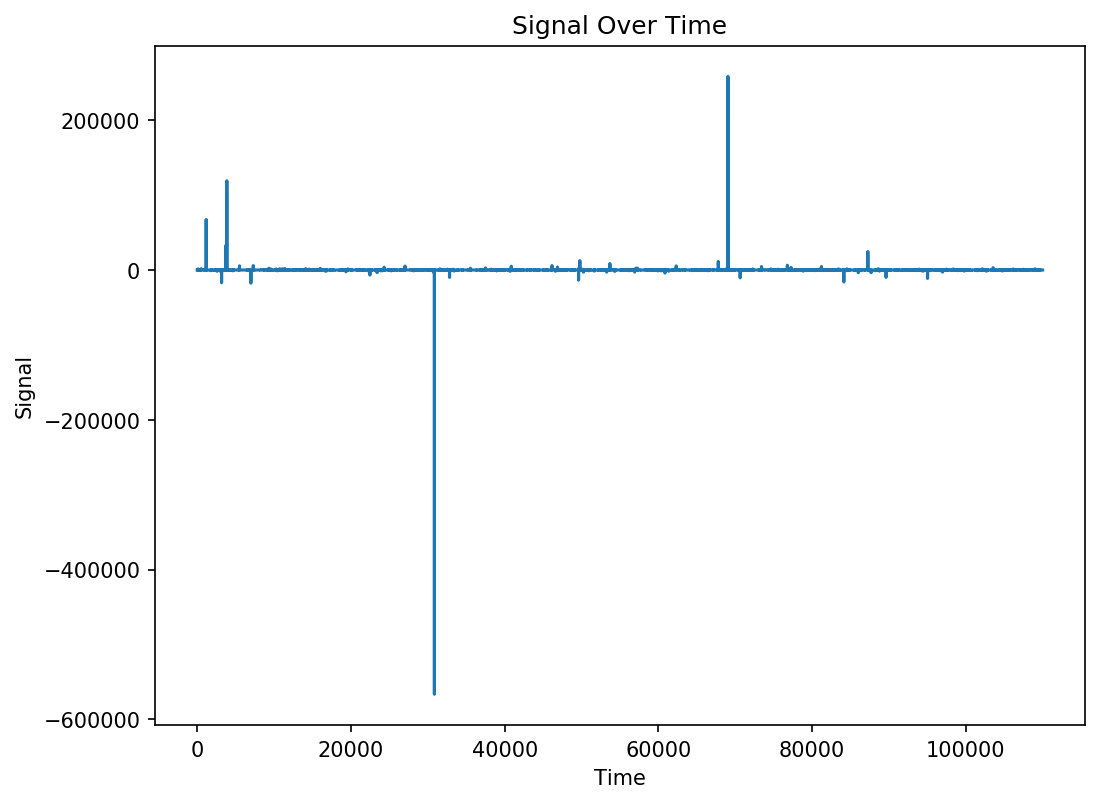

In [188]:
time = x.shape[1]

plt.figure(figsize=[8,6], dpi=150)
plt.plot(range(time), x[0, :time])
plt.ylabel("Signal")
plt.xlabel("Time")
plt.title("Signal Over Time")
plt.show()

# Iterative Loop

In [189]:
w_record = []
dot_product_record = []
loss_record = []

In [190]:
j=1
while(True):
    if j % 10 == 0:
        print("Iteration %d is starting" % j)
        
    w_new = update_w(w, x, t, sample_size)

    loss, dot_product, has_converged = w_has_converged(w, w_new, threshold)
    
    if has_converged:
        print("here")
        break
    w = w_new
    w_record.append(w)
    loss_record.append(loss)
    dot_product_record.append(dot_product)
    j = j + 1

/Users/srivatsavpyda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in cosh
  This is separate from the ipykernel package so we can avoid doing imports until


Iteration 10 is starting
Iteration 20 is starting
Iteration 30 is starting
Iteration 40 is starting
Iteration 50 is starting
Iteration 60 is starting
Iteration 70 is starting
Iteration 80 is starting
Iteration 90 is starting
Iteration 100 is starting
Iteration 110 is starting
Iteration 120 is starting
Iteration 130 is starting
Iteration 140 is starting
Iteration 150 is starting
Iteration 160 is starting
Iteration 170 is starting
Iteration 180 is starting
Iteration 190 is starting
Iteration 200 is starting
Iteration 210 is starting
Iteration 220 is starting
Iteration 230 is starting
Iteration 240 is starting
Iteration 250 is starting
Iteration 260 is starting
Iteration 270 is starting
Iteration 280 is starting
Iteration 290 is starting
Iteration 300 is starting
Iteration 310 is starting
Iteration 320 is starting
Iteration 330 is starting
Iteration 340 is starting
Iteration 350 is starting
Iteration 360 is starting
Iteration 370 is starting
Iteration 380 is starting
Iteration 390 is star

KeyboardInterrupt: 

In [170]:
print(len(w_record))

3439


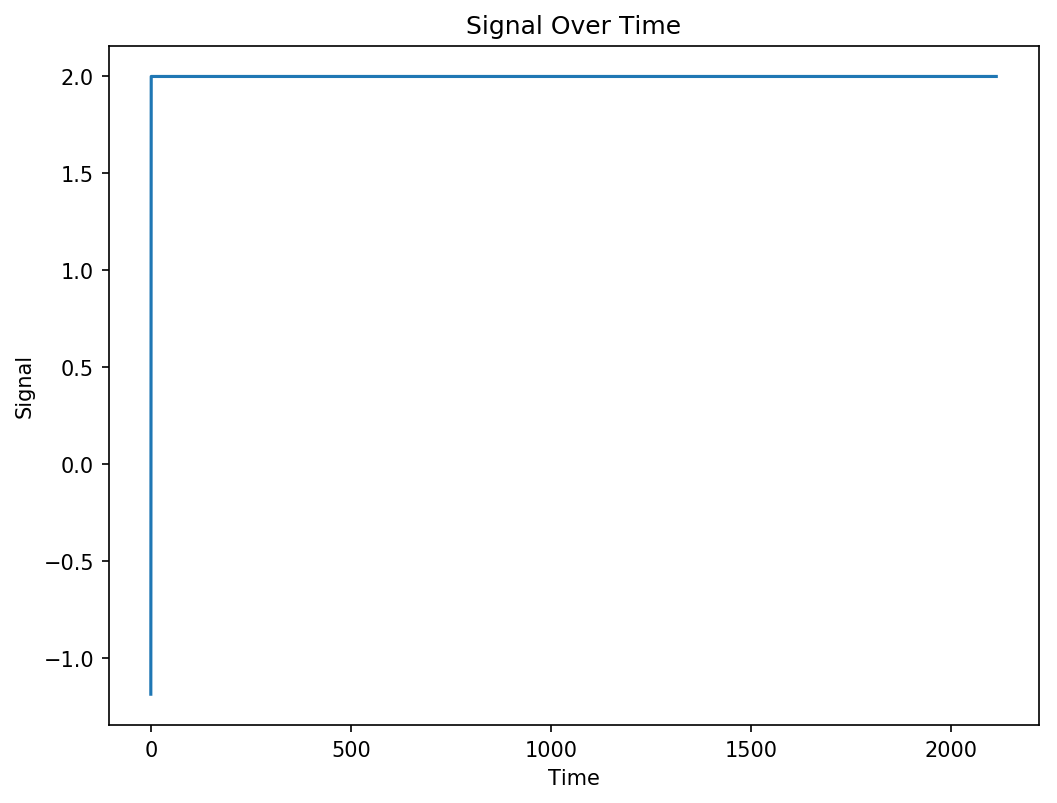

In [191]:
plt.figure(figsize=[8,6], dpi=150)
plt.plot(range(len(dot_product_record)), dot_product_record)
plt.ylabel("Signal")
plt.xlabel("Time")
plt.title("Signal Over Time")
plt.show()

In [192]:
print(dot_product_record[:100])

[-1.185357642765295, 1.9999999971909501, 1.9999999999999998, 1.9999999999999998, 2.0, 2.0000000000000004, 2.0, 2.0, 2.0, 1.9999999999999996, 1.9999999999999996, 1.9999999999999998, 1.9999999999999998, 1.9999999999999996, 2.0, 2.0, 1.9999999999999998, 2.0, 2.0, 1.9999999999999996, 1.9999999999999996, 1.9999999999999996, 2.0, 2.0000000000000004, 2.0000000000000004, 2.0, 2.0, 2.0000000000000004, 2.0, 2.0, 2.0000000000000004, 2.0, 1.9999999999999998, 2.0, 2.0, 2.0, 1.9999999999999998, 1.9999999999999998, 1.9999999999999998, 1.9999999999999996, 1.9999999999999996, 2.0, 2.0000000000000004, 2.0, 1.9999999999999998, 1.9999999999999996, 2.0, 2.0000000000000004, 2.0000000000000004, 2.0000000000000004, 2.0, 1.9999999999999996, 1.9999999999999998, 1.9999999999999998, 2.0, 2.0000000000000004, 2.0, 1.9999999999999998, 1.9999999999999998, 2.0, 1.9999999999999998, 1.9999999999999998, 1.9999999999999998, 2.0, 2.0000000000000004, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0000000000000004, 2.0, 2.0, 2.0, 2.0, 2.0,

In [193]:
w_record[:100]

[array([[-0.70715665, -0.70705691],
        [-0.70708885, -0.70712471]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.70710678, -0.70710678]]), array([[-0.70710678, -0.70710678],
        [-0.707